# Groundwater Flow Induced by Topography

The darcy flow solver, ``uw.systems.SteadyStateDarcyFlow``, can solve for ground-water flow induced by an imposed pressure-gradient. In this example we show how groundwater flow beneath hetereogeneous topography can be modelled in each of these two ways.

A simple 2D hill model is set up with 2 layers, which are assigned hydraulic and thermal properties.

This script tests the mesh resolution and particles per cell to resolve a layer that pinches to a thickness of ~100 m at the middle of the model

In [1]:
import underworld as uw
import underworld.visualisation as vis
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
uw.utils.matplotlib_inline()

import os 

os.environ["UW_ENABLE_TIMING"] = "1"

In [2]:
x = np.arange(0, 30000)
layer_thickness = 500*(np.cos(x/5000)+1.2)

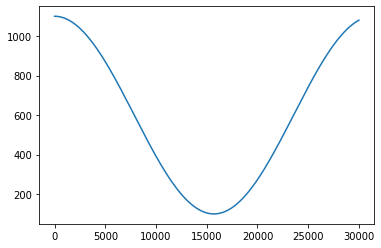

In [3]:
plt.plot(x, layer_thickness)

### define function that runs the model at different resolutions

In [4]:
def res_test(resX, resY, layer_thickness, gaussPointCount):
    
    uw.timing.start()
    
    
    deformedmesh = True
    elementType = "Q1"
    
    mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                     elementRes  = (resX, resY), 
                                     minCoord    = (0., -12000.), 
                                     maxCoord    = (30000., 0.)) 

    gwHydraulicHeadField       = mesh.add_variable( nodeDofCount=1 )
    hydraulicDiffusivityField  = mesh.add_variable( nodeDofCount=1 )
    velocityField              = mesh.add_variable(nodeDofCount=2)
    
    xcoords = np.linspace(0,30000,resX)
    ycoords = np.linspace(-12000,0,resY)

    # Set up topography
    hillsize = 0.5
    hillwavelength = 1.0/26000.0

    # pick depth above which to deform mesh
    ydeform = -0.5

    def topo_coords(x, hillsize, hillwavelength):
        return hillsize*x/4*np.cos(x*hillwavelength*np.pi)
    
    # Set up topography
    hillsize = 0.5
    hillwavelength = 1.0/26000.0

    # pick depth above which to deform mesh
    ydeform = -10000.

    yCoordFn = uw.function.input()[1]
    xCoordFn = uw.function.input()[0]

    # ramp option
    ydel = hillsize  * (xCoordFn )/4. * uw.function.math.cos(xCoordFn * hillwavelength * np.pi)

    if deformedmesh:
        with mesh.deform_mesh():
            for i in range(len(mesh.data[:])):
                y = mesh.data[i,1]
                if y >= ydeform:
                    delY = ydel.evaluate((mesh.data[i,0],mesh.data[i,1])) #0.1 * (mesh.data[i,0] + 1.)/2.
                    dY = (y - ydeform)/(-ydeform) * delY

                    mesh.data[i,1] += dY
                    
    iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
    jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
    topWall = mesh.specialSets["MaxJ_VertexSet"]
    bottomWall = mesh.specialSets["MinJ_VertexSet"]


    gwHydraulicHeadBC = uw.conditions.DirichletCondition( variable        = gwHydraulicHeadField, 
                                                          indexSetsPerDof = ( topWall   ) )

    # assign the hydraulic head upper BC to match the mesh
    gwHydraulicHeadField.data[:] = yCoordFn.evaluate(mesh)
    
    
    swarm         = uw.swarm.Swarm( mesh=mesh )
    swarmLayout = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm,gaussPointCount=gaussPointCount)
    swarm.populate_using_layout( layout=swarmLayout )
    
    materialIndex        = swarm.add_variable( dataType="int",    count=1 )
    swarmVelocity        = swarm.add_variable( dataType="double", count=2 )
    hydraulicDiffusivity = swarm.add_variable( dataType="double", count=1 )


    materialPorous        = 0
    materialImpermeable   = 1

    xCoordFn = uw.function.input()[0]
    yCoordFn = uw.function.input()[1]

    conditions = [ (yCoordFn > -0.5, materialPorous),
                   (xCoordFn < -1. , materialPorous),
                   (True , materialImpermeable )]


    # materialIndex.data[:]  = uw.function.branching.conditional( conditions ).evaluate(swarm)
    
    
    materialIndex.data[:] = 1
    hydraulicDiffusivity.data[:] = 1e-12
    
    f = interpolate.interp1d(x, (mesh.minCoord[1] / 2) - layer_thickness)
    
    materialIndex.data[:][(swarm.data[:,1] < (mesh.minCoord[1] / 2)) & (swarm.data[:,1] > f(swarm.data[:,0]))] = 2
    
    # materialIndex.data[:][(swarm.data[:,1] < (mesh.minCoord[1] / 2)) & (swarm.data[:,1] > f(swarm.data[:,0]))] = 2


    hydraulicDiffusivity.data[materialIndex.data[:] == 2] = 1e-4
    
    
    hydraulicDiffusivity.data[:,0] = np.repeat((np.average((np.split(hydraulicDiffusivity.data[:,0], np.unique(swarm.owningCell.data[:,0], return_index = True)[1])[1:]), axis=1)), gaussPointCount**mesh.dim)
    
    figMaterial = vis.Figure( figsize=(900,400), title="Initial Material Distribution" )
    figMaterial.append( vis.objects.Points(swarm, materialIndex, pointSize=3.0) )
#     figMaterial.append( vis.objects.Mesh(mesh))
    # figMaterial.append( vis.objects.Mesh(mesh))
    figMaterial.show()
    
    figMaterial = vis.Figure( figsize=(900,400), title="Hydraulic diffusivity" )
    figMaterial.append( vis.objects.Points(swarm, hydraulicDiffusivity, pointSize=3.0) )
#     figMaterial.append( vis.objects.Mesh(mesh))
    # figMaterial.append( vis.objects.Mesh(mesh))
    figMaterial.show()
    
    
    
    gwadvDiff = uw.systems.SteadyStateDarcyFlow(velocityField=velocityField,
                                                pressureField = gwHydraulicHeadField, 
                                                fn_diffusivity = hydraulicDiffusivity,
                                                conditions=[gwHydraulicHeadBC],
                                                fn_bodyforce=(0., 0.,),
                                                voronoi_swarm=swarm,
                                                swarmVarVelocity=swarmVelocity)


    gwsolver = uw.systems.Solver(gwadvDiff)
    
    gwsolver.solve()
    
    figMaterial = vis.Figure( figsize=(900,400),title="Ground-Water Hydraulic Head and Velocity Vectors" )
    figMaterial.append(vis.objects.Surface(mesh, gwHydraulicHeadField, onMesh=True))
    figMaterial.append(vis.objects.VectorArrows(mesh,velocityField,scaling=1,arrowHead=0.3))
    figMaterial.show()

    print("max velocity = {}".format(np.abs(velocityField.data).max()))
    
    # If in parallel, every CPU will report these metrics for its own domain.
    print("Max horiz. velocity: %.4e" %np.max(abs(swarmVelocity.data[:,0])))
    print("Max vert. velocity: %.4e" %np.max(abs(swarmVelocity.data[:,1])))
    
    print("Average horiz. velocity: %.4e" %np.average(abs(swarmVelocity.data[:,0])))
    print("Average vert. velocity: %.4e" %np.average(abs(swarmVelocity.data[:,1])))
    
    print("Max pressure: %.4e" %np.max(gwHydraulicHeadField.data[:]))
    print("Min pressure: %.4e" %np.min(gwHydraulicHeadField.data[:]))
    
    print("Average pressure: %.4e" %np.average(gwHydraulicHeadField.data[:]))
    
    uw.timing.stop()
    # module_timing_data_orig = uw.timing.get_data(group_by="routine")
    
    run_time = uw.timing._endtime-uw.timing._starttime
    
    return run_time

    
    

46.875
468.75



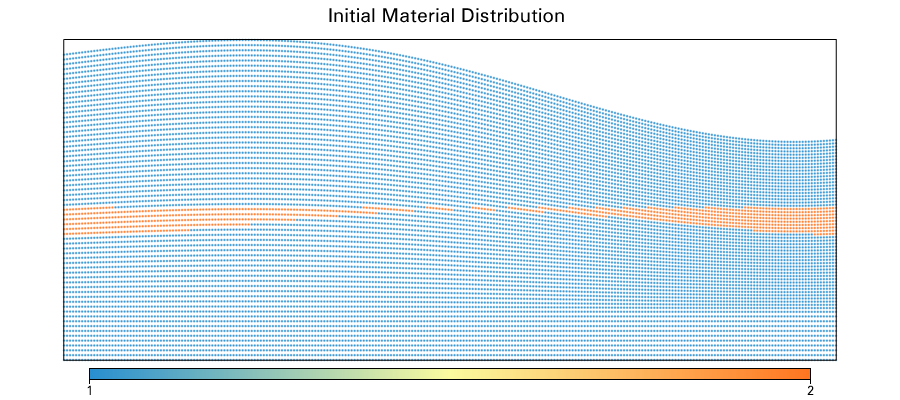


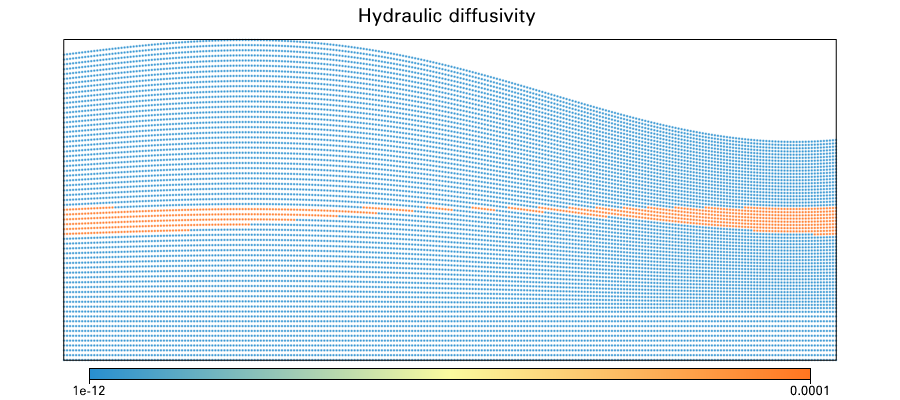


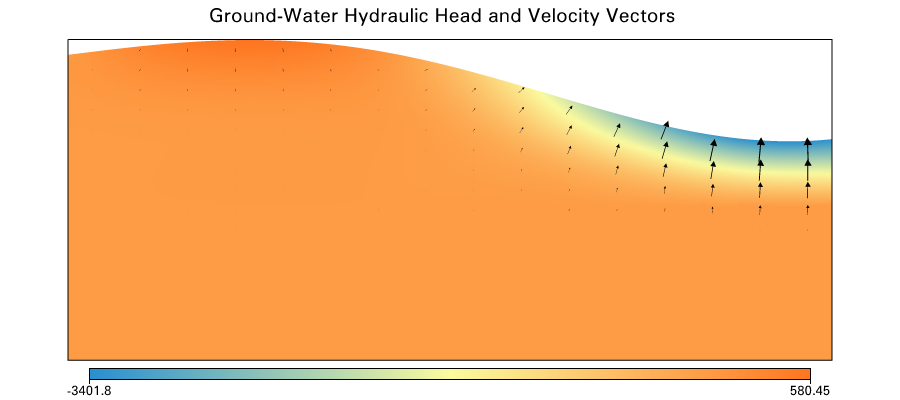

max velocity = 1.7536764290403233e-12
Max horiz. velocity: 5.0466e-13
Max vert. velocity: 1.7538e-12
Average horiz. velocity: 3.9069e-14
Average vert. velocity: 1.5766e-13
Max pressure: 5.8045e+02
Min pressure: -3.4018e+03
Average pressure: -1.6501e+02
run time: 7.0309e+00


In [5]:
resX = 256
resY = 64

vertical_res = 12000 / resX
horizontal_res = 30000 / resY

print(vertical_res)
print(horizontal_res)

run_time = res_test(resX=resX, resY=resY, layer_thickness=layer_thickness, gaussPointCount=1)

print("run time: %.4e" %run_time)

46.875
468.75



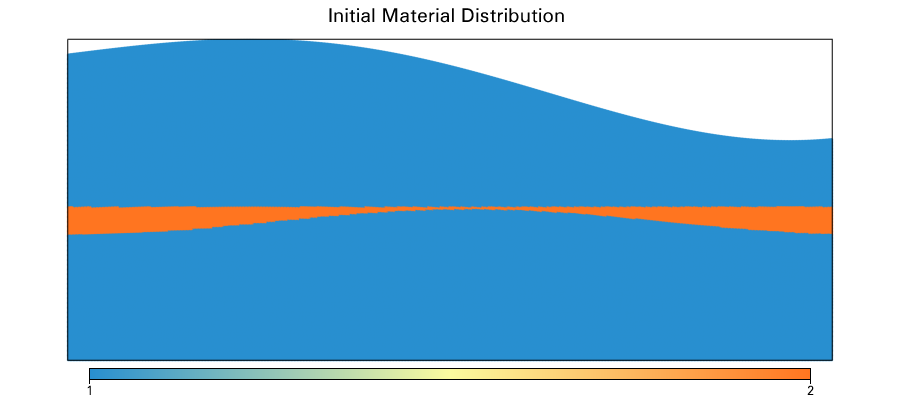


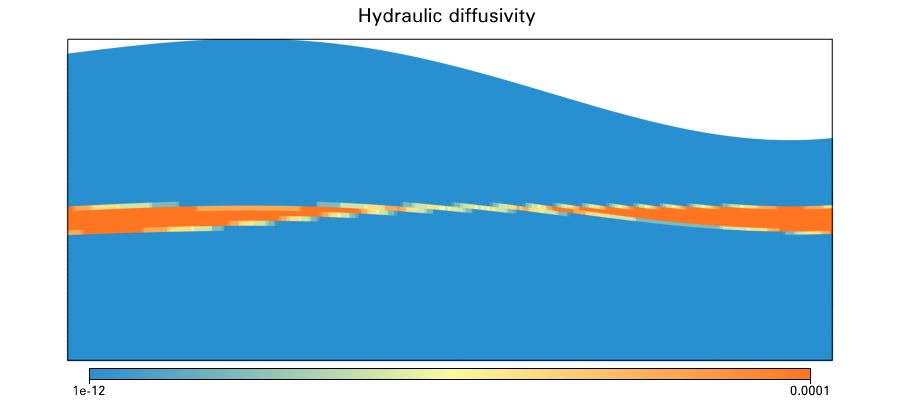

/opt/venv/lib/python3.8/site-packages/underworld/systems/_darcyflow.py:123: UserWarning: It is not advised to fill any cell with more than one particle, as the Q1 shape function cannot capture material interfaces. Use at your own risk.
  warnings.warn("It is not advised to fill any cell with more than one particle, as the Q1 shape function cannot capture material interfaces. Use at your own risk.")



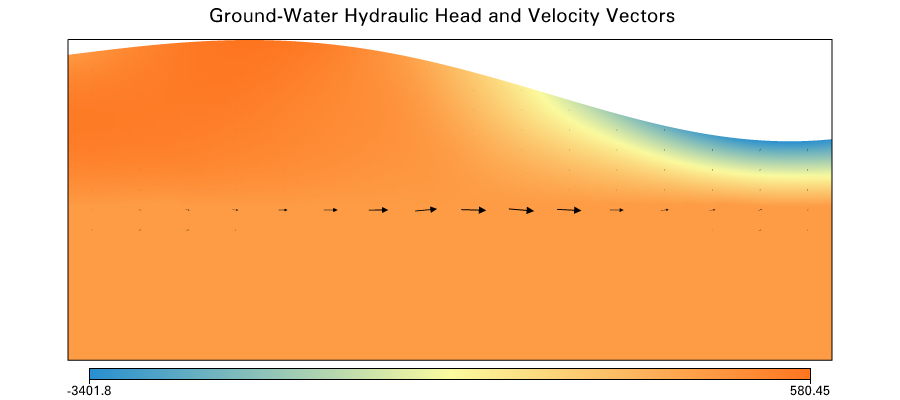

max velocity = 1.6394179473115994e-11
Max horiz. velocity: 3.4058e-11
Max vert. velocity: 6.3302e-12
Average horiz. velocity: 3.8027e-13
Average vert. velocity: 1.8360e-13
Max pressure: 5.8045e+02
Min pressure: -3.4018e+03
Average pressure: -1.3088e+02
run time: 1.0809e+01


In [6]:
resX = 256
resY = 64

vertical_res = 12000 / resX
horizontal_res = 30000 / resY

print(vertical_res)
print(horizontal_res)


run_time = res_test(resX=resX, resY=resY, layer_thickness=layer_thickness, gaussPointCount=5)

print("run time: %.4e" %run_time)